To perform hyperparameter optimization, use this script !<br>
Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [1]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [2]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [3]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [8]:
dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [9]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [10]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,186.323949,-0.733565
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,56.940496,57.865151
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,90.038520,-89.957853
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,133.386049,-55.497208
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,192.348882,-1.876044
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,239.985376,54.717045
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,269.907884,89.975398


In [11]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [13]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [14]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [15]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [16]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [17]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [18]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,0.104064,7.648595,181.033749,52.930471
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,0.104050,6.700397,189.014812,36.481737
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,0.092759,4.089472,180.106505,44.814586
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,0.093128,3.821501,187.773943,70.701850
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,0.086621,5.479353,203.118792,52.780582


In [19]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [20]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [21]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


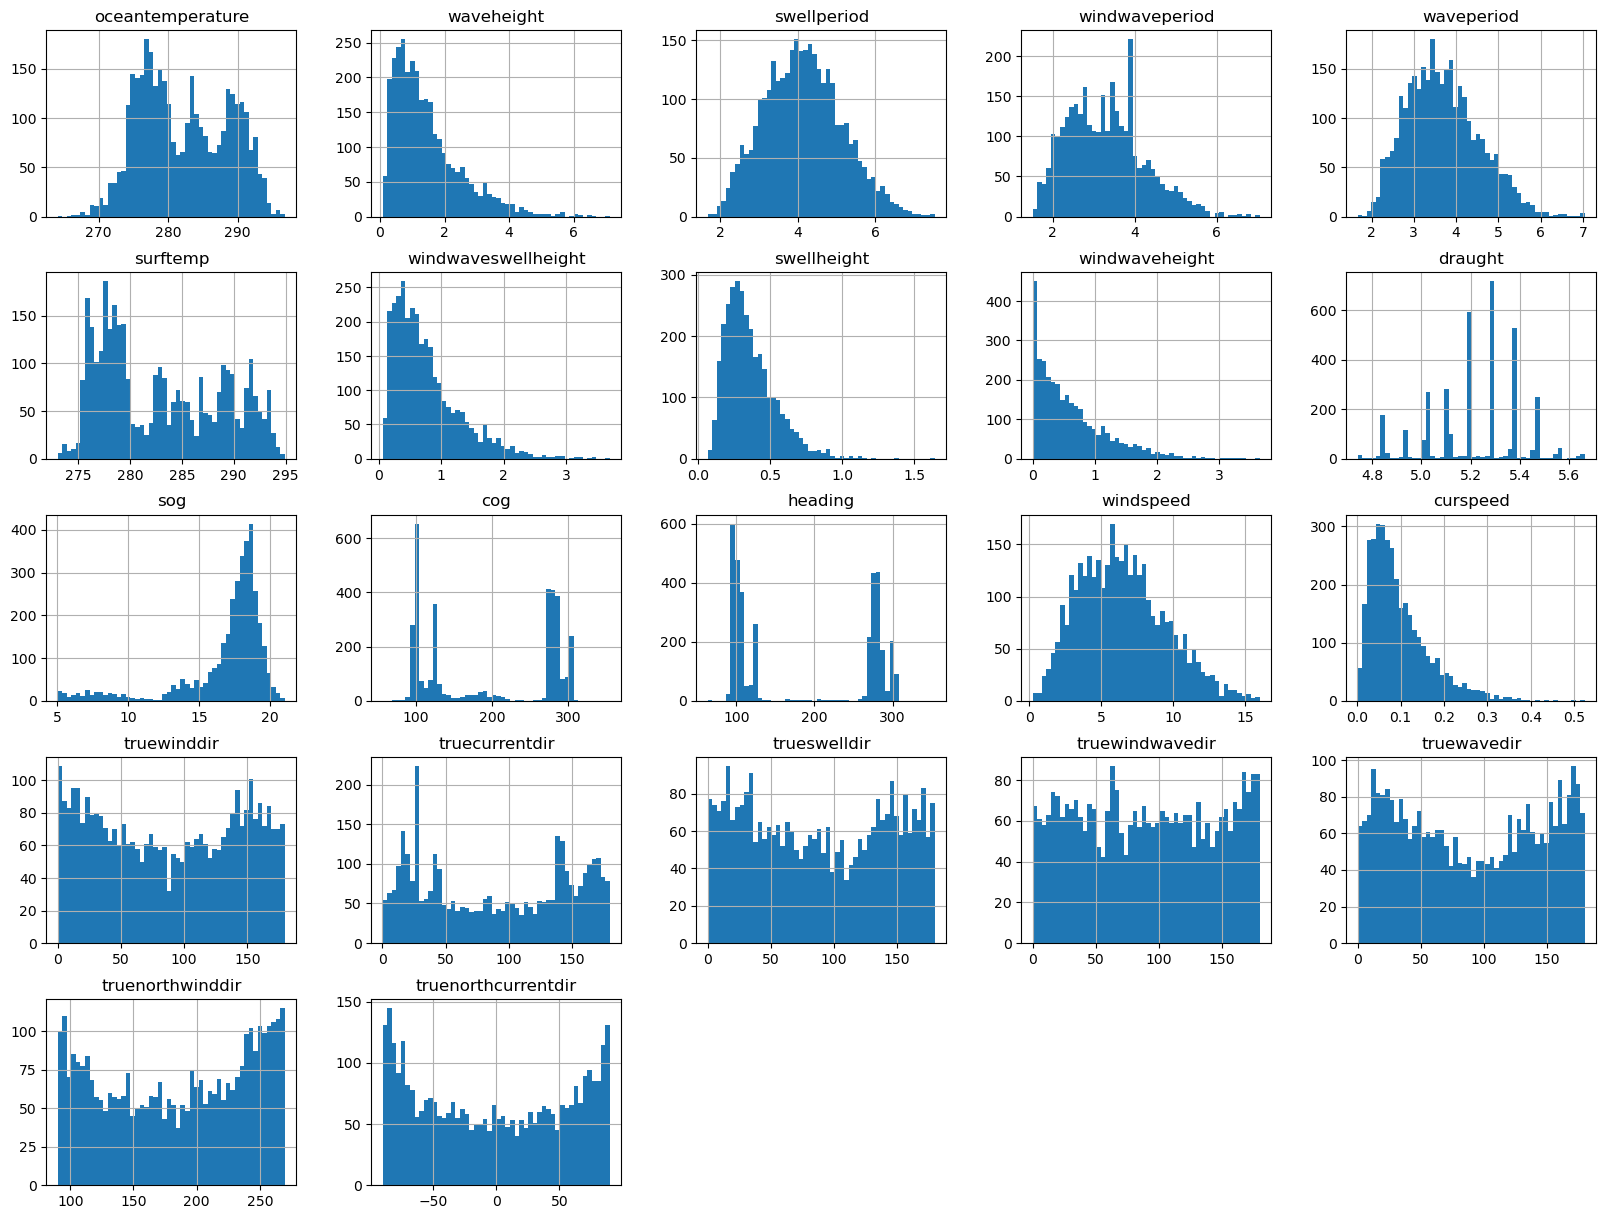

In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

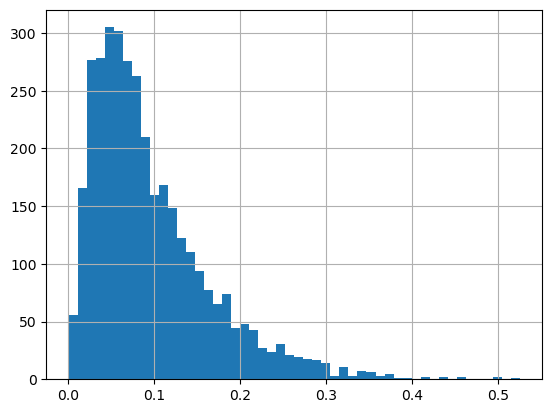

In [23]:
df_ship2['curspeed'].hist(bins=50)
plt.show()

In [24]:
hhstats = df_ship2.describe()
print(hhstats)

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       3506.000000  3152.000000  3152.000000     3152.000000   
mean         282.187439     1.457923     4.140942        3.299684   
std            6.345629     1.052465     0.991532        0.939149   
min          264.076782     0.083379     1.681843        1.517006   
25%          276.908691     0.671875     3.416050        2.559944   
50%          281.418823     1.180761     4.102280        3.239967   
75%          288.072144     1.928374     4.810565        3.864906   
max          296.830322     7.120887     7.531564        7.052921   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  3152.000000  3391.000000          3152.000000  3152.000000   
mean      3.698114   283.014106             0.766249     0.359745   
std       0.862321     5.765232             0.538023     0.175846   
min       1.672565   273.048584             0.065236     0.065332   
25%       3.049094   277.872803  

Feature Selection

In [25]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
windspeed              0.117765
curspeed               0.137821
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
truenorthwinddir       0.011171
truenorthcurrentdir    0.013469
Name: sog, dtype: float64


In [26]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

,waveheight,swellperiod,windwaveperiod,waveperiod,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed
8,1.661038,4.291309,3.667458,3.757862,0.865413,0.323892,0.801956,5.017723,14.578394,299.573513,269.900574,7.648595,0.104064
9,1.501637,4.187211,3.145607,3.803910,0.785675,0.452440,0.578049,5.019207,18.148696,302.274508,300.130435,6.700397,0.104050
10,1.235528,4.012717,2.120399,3.819602,0.654636,0.556525,0.236435,5.019664,9.686510,163.922318,230.117302,4.089472,0.092759
11,1.204397,4.020009,2.090308,3.820546,0.638782,0.555405,0.226181,5.019009,11.252112,117.003285,178.653615,3.821501,0.093128
12,1.275907,4.095175,3.029945,3.815268,0.674081,0.598373,0.263031,5.020452,18.119627,125.829385,125.446296,5.479353,0.086621


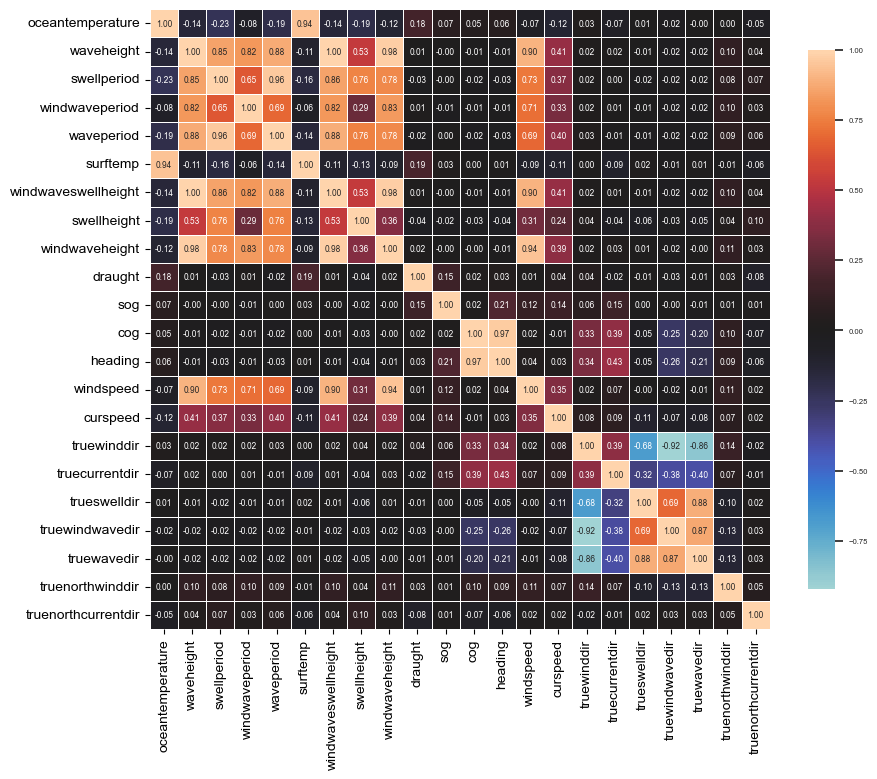

In [27]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

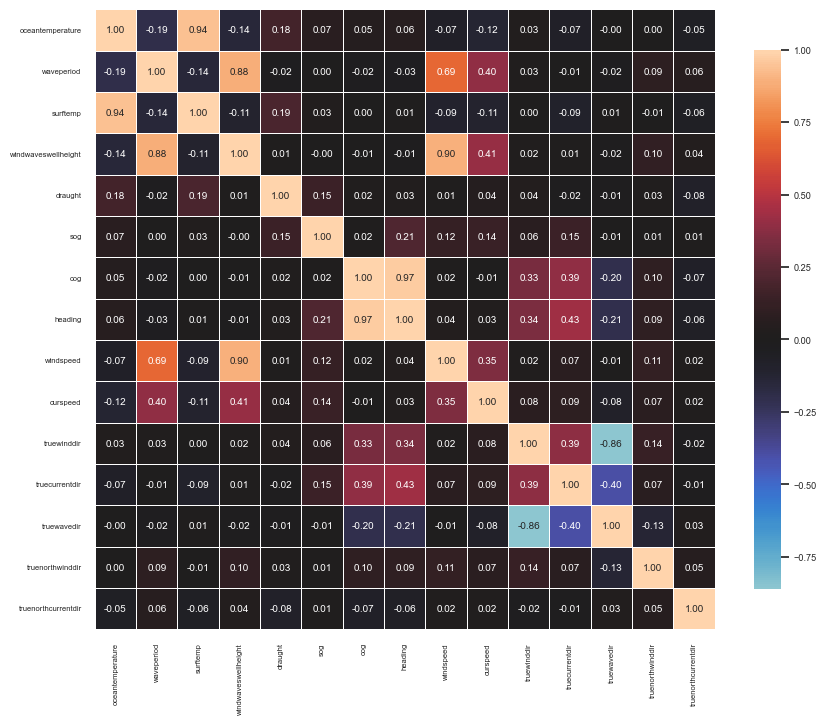

In [28]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir'],axis=1)
correlation_heatmap(df_ship2,.6)

In [29]:
# dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

# correlation_heatmap(dfship_corrftf,1)

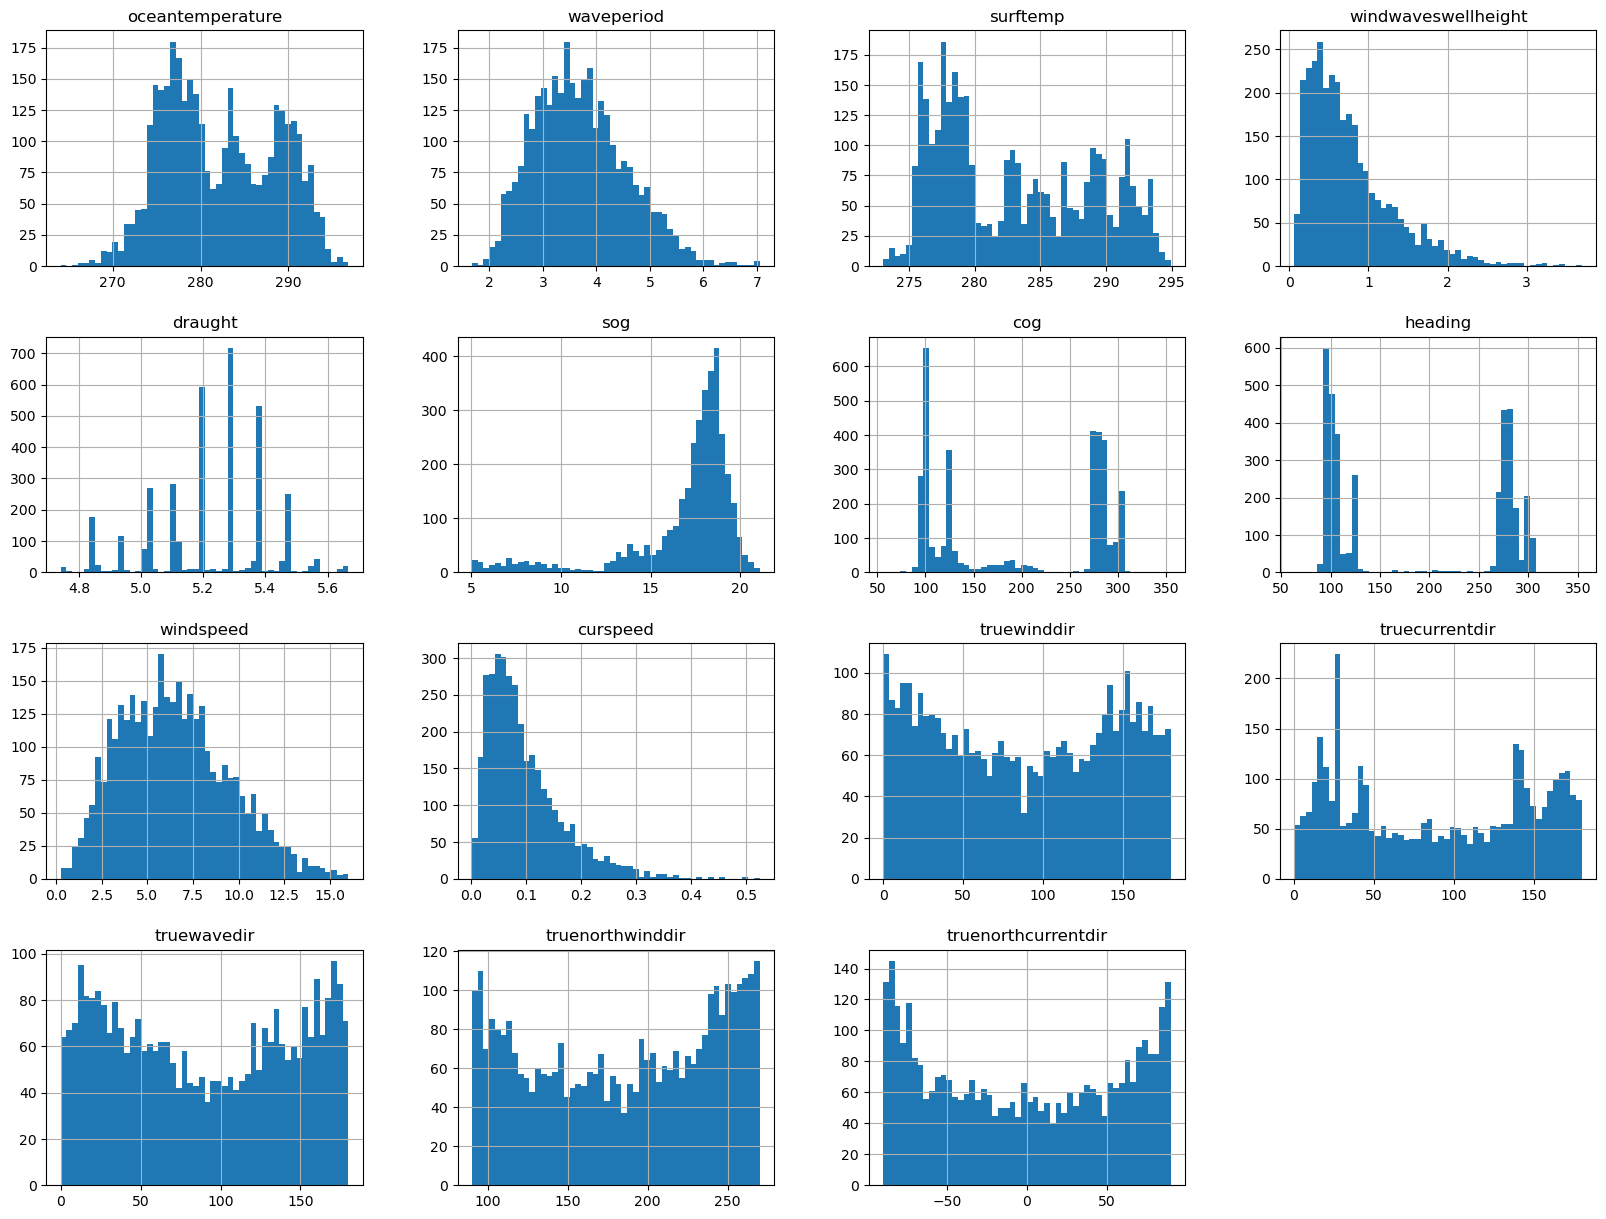

In [30]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

In [31]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [32]:
df_ship2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3152 non-null   float64
 2   surftemp             3391 non-null   float64
 3   windwaveswellheight  3152 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3152 non-null   float64
 13  truenorthwinddir     3506 non-null   float64
 14  truenorthcurrentdir  3506 non-null   float64
dtypes: float64(15)
memory usage: 438.2 KB


Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [33]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [34]:
X = imputer.transform(df_ship2)

In [35]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [36]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3506 non-null   float64
 2   surftemp             3506 non-null   float64
 3   windwaveswellheight  3506 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3506 non-null   float64
 13  truenorthwinddir     3506 non-null   float64
 14  truenorthcurrentdir  3506 non-null   float64
dtypes: float64(15)
memory usage: 438.2 KB


Data Split for training and test data

In [37]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truenorthcurrentdir','truenorthwinddir']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [38]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [39]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [40]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [41]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=230,
                                  max_features=9,
                                  random_state=42, 
                                  )
model_rfr_ftr_hpo.fit(x_train,y_train)

RandomForestRegressor(max_features=9, n_estimators=230, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 267,
                                            min_samples_split = 5,
                                            #min_samples_leaf = 2,
                                            max_features = 9,
                                            max_depth=136,
                                            bootstrap=False,
                                            random_state=42)
model_rfr_ftr_hpov.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)

ETR TRAINING

In [43]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42,
                                )
model_etr.fit(x_train,y_train)

ExtraTreesRegressor(random_state=42)

In [44]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpo = ExtraTreesRegressor(random_state=42,
                                n_estimators=400)
model_etr_hpo.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=400, random_state=42)

Modelling using Decision Tree Regressor

In [45]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [46]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=10,
                                  min_samples_leaf=9,
                                  max_features=12,
                                  max_depth=90)
model_dtr_hpov.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=90, max_features=12, min_samples_leaf=9,
                      min_samples_split=10)

Modelling using Multiple Linear Regression

In [47]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

In [48]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=8,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(25,5,model_rfr_ftr_hpo)

In [49]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr_ftr_hpo)

                     Importance
oceantemperature       0.006400
waveperiod             0.009295
surftemp               0.007321
windwaveswellheight    0.011170
draught                0.023940
cog                    0.482946
heading                0.398495
windspeed              0.006688
curspeed               0.015701
truewinddir            0.005712
truecurrentdir         0.025928
truewavedir            0.006406


Evaluation of RFR

In [50]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr_ftr)
display_scores(x_test,y_test,model_rfr_ftr)


R^2 score (Indicate model fit. Best Score = 1): 0.934206974964408
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.934245014624783
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5543582735344158
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.6948798108958671
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.3953739056500023


Evaluation of model with FTR + HPO

In [51]:
y_predicted = predict_y(x_test,model_rfr_ftr_hpo)
display_scores(x_test,y_test,model_rfr_ftr_hpo)

R^2 score (Indicate model fit. Best Score = 1): 0.9326486585869368
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9326997741861848
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5490040731361646
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.7113381298302416
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.39367443120434364


Evaluation of DTR

In [52]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8477599489737424
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8480791278871431
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8441408143732194
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.6078989803352948
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5907151699999993


Evaluation of MLR 

In [53]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6908618365428102
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.691144076994931
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.1382252430984632
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.264994555997687
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.8922183121019591


In [54]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.054192
waveperiod               0.514791
surftemp                -0.059784
windwaveswellheight     -1.069902
draught                  2.078703
cog                     -0.115479
heading                  0.116229
windspeed                0.098651
curspeed                -0.640204
truewinddir             -0.001208
truecurrentdir          -0.000386
truewavedir             -0.000715


Saving model to local directory

In [55]:
# Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)


filename = 'savemodel_dtr_ftr_hpov.sav'
joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

['savemodel_dtr_ftr_hpov.sav']

Hyperparameter Optimization

RFR HPO fot test data

In [56]:
from pprint import pprint
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [57]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#             #    'max_features': max_features,
#             #    'max_depth': max_depth,
#             #    'min_samples_split': min_samples_split,
#             #    'min_samples_leaf': min_samples_leaf,
#             #    'bootstrap': bootstrap}
# pprint(random_grid)

In [58]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# # rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [59]:
# rf_random.best_params_

In [60]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# # base_model = model_rfr_ftr
# # base_model.fit(x_train, y_train)
# # rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# # best_random = rf_random.best_estimator_
# # rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# # print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# # print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# # print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# # print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# # print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

HPO for DTR test data

In [61]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [62]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_train, y_train)

In [64]:
# dt_random.best_params_

In [65]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

ETR

In [66]:
# from pprint import pprint
# pprint(model_etr.get_params())

In [67]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]

# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#                #'max_features': max_features,
#                #'max_depth': max_depth,
#                #'min_samples_split': min_samples_split,
#                #'min_samples_leaf': min_samples_leaf,
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [68]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [69]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_etr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = rf_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [70]:
# rf_random.best_params_

HPO for validation data 

In [71]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,201.771601,85.654121
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,205.671971,70.585227
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,212.436488,70.557348
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,230.510505,80.584748
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,254.157471,89.447596


In [72]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [73]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)

In [74]:
dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


In [75]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [76]:
xdate = imputer.transform(dfdate6)

In [77]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [78]:
x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

ETR HPO Validation Data

In [79]:
from pprint import pprint
pprint(model_etr.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [80]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
max_depth = [None]
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators}
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap}
pprint(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [82]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
etr_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
etr_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=1, verbose=2)

In [95]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD
base_model = model_etr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

etr_best_random = etr_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(etr_best_random, x_date, y_date)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of ExtraTreesRegressor(random_state=42)
R^2: 0.8762
explained Variance = 0.8940
MAE = 0.8026
RMSE = 1.0786
MAD = 0.6210

Model Performance of ExtraTreesRegressor(n_estimators=400, random_state=42)
R^2: 0.8750
explained Variance = 0.8933
MAE = 0.8097
RMSE = 1.0838
MAD = 0.6500

Improvement of Rsquared -0.136%.
Improvement of explainedVariance -0.079%.
Improvement of MAE -0.895%.
Improvement of RMSE -0.481%.
Improvement of MAD -4.660%.


In [85]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 21)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

In [86]:
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [87]:
# rf_random.best_params_

In [88]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_ftr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# # best_random = rf_random.best_estimator_
# best_random = model_rfr_ftr_hpov
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

DTR + HPO Validation data 

In [89]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [90]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_train, y_train)

In [91]:
# dt_random.best_params_

In [92]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [93]:
# print(dt_random.best_estimator_)